We first implement the baseline model proposed by the paper "Yoga-82: A New Dataset for Fine-grained Classification of Human Poses".

In the paper, the author proposed to modify DenseNet-201 by creating branches for different levels of classifications. 

In this notebook, we will implement variant 2 which branches out before DenseBlock 4 for first and second level classifications as shown in below fig.

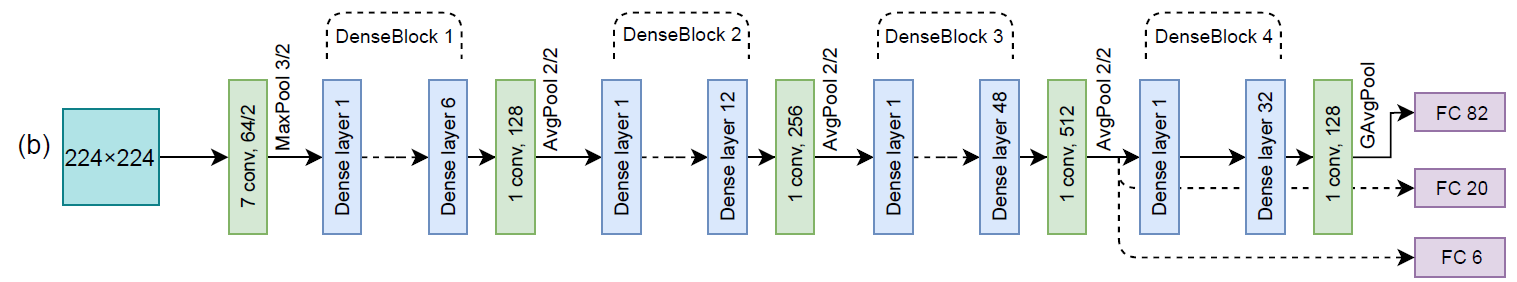

Let's define the model using pytorch:

We first load DenseNet-201. Then we branch out the model before DenseBlock 4.

By referencing the implementation at https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py, we learn that DenseNet-201 has below 12 layers:

0. conv0
1. norm0
2. relu0
3. pool0
4. denseblock1
5. transition1
6. denseblock2
7. transition2
8. denseblock3
9. transition3
10. denseblock4
11. norm5

We will branch out before transition3 for first and second level classifications.

In addition, according to the paper, we will apply batch normalization, ReLU activation and global average pooling for all branches.

In [14]:
import torch.nn as nn
import torchvision.models as models

class DenseNet201Variant2(nn.Module):

    def __init__(self, num_classes1, num_classes2, num_classes3):
        super(DenseNet201Variant2, self).__init__()
        
        # Load DenseNet-201 backbone without any weights
        densenet = models.densenet201(weights=None)
        features_list = list(densenet.features.children())

        # branch out after denseblock3 and before transition3
        self.branch_features = nn.Sequential(*features_list[:9])
        self.main_features = nn.Sequential(*features_list[9:])

        # Head layers for branch and main features
        self.branch_head = nn.Sequential(
            nn.BatchNorm2d(1792),
            nn.ReLU(inplace=True)
        )
        self.main_head = nn.Sequential(
            nn.BatchNorm2d(1920),
            nn.ReLU(inplace=True)
        )

        # Global average pooling converts feature maps into a feature vector.
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for classification at each hierarchical level.
        self.fc_level1 = nn.Linear(1792, num_classes1)
        self.fc_level2 = nn.Linear(1792, num_classes2)
        self.fc_level3 = nn.Linear(1920, num_classes3)
    
    def forward(self, x):
        
        # Extract features for the main and branch.
        x_branch = self.branch_features(x)
        x_main = self.main_features(x_branch)
        
        # Process branch features.
        branch_feature = self.branch_head(x_branch)
        branch_feature = self.global_pool(branch_feature).view(x.size(0), -1)
        
        # Process main branch features.
        main_feature = self.main_head(x_main)
        main_feature = self.global_pool(main_feature).view(x.size(0), -1)
        
        # Get predictions from fully connected layers.
        class1 = self.fc_level1(branch_feature)
        class2 = self.fc_level2(branch_feature)
        class3 = self.fc_level3(main_feature)
        
        return class1, class2, class3

Next we will prepare the dataset to train and test the model.

First, we will create a custom dataset class that can handle the hierarchical labels. This dataset will be used to load the data and provide it to the model during training and testing.



In [15]:
# -----------------------------
# Dataset definition
# -----------------------------


from torch.utils.data import Dataset
from torchvision import transforms

class YogaPoseDatasetMultiTask(Dataset):
    """
    Expects each row in the text file to be:
      <folder>/<file>,<L1 label>,<L2 label>,<L3 label>
    Builds sorted lists for each level and a hierarchy mapping (L3 -> (L1, L2)).
    """
    def __init__(self, txt_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # list of tuples: (full_image_path, L1, L2, L3) as strings
        with open(txt_file, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split(',')
                if len(parts) != 4:
                    continue
                image_rel_path, l1, l2, l3 = parts
                full_path = os.path.join(root_dir, image_rel_path)
                self.data.append((full_path, l1, l2, l3))
        
        # Build sorted unique label lists for each level
        self.labels1 = sorted(list({l1 for (_, l1, _, _) in self.data}))
        self.labels2 = sorted(list({l2 for (_, _, l2, _) in self.data}))
        self.labels3 = sorted(list({l3 for (_, _, _, l3) in self.data}))
        
        # Build hierarchical mapping: for each L3 index, store its corresponding (L1 index, L2 index)
        self.hierarchy_mapping = {}
        for (_, l1, l2, l3) in self.data:
            l1_idx = self.labels1.index(l1)
            l2_idx = self.labels2.index(l2)
            l3_idx = self.labels3.index(l3)
            if l3_idx in self.hierarchy_mapping:
                if self.hierarchy_mapping[l3_idx] != (l1_idx, l2_idx):
                    print(f"Warning: Inconsistent hierarchy for L3 label '{l3}': {self.hierarchy_mapping[l3_idx]} vs {(l1_idx, l2_idx)}")
            else:
                self.hierarchy_mapping[l3_idx] = (l1_idx, l2_idx)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, l1, l2, l3 = self.data[index]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}. Returning a black image.")
            image = Image.new('RGB', (224, 224))
        # Apply provided transform or a default transform to ensure consistent size.
        if self.transform:
            image = self.transform(image)
        else:
            default_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
            image = default_transform(image)
        # Get label indices
        l1_idx = self.labels1.index(l1)
        l2_idx = self.labels2.index(l2)
        l3_idx = self.labels3.index(l3)
        return image, l1_idx, l2_idx, l3_idx


Now let's initialize Training Variables and Hyperparameters

Below, we set the number of epochs, batch size, and early stopping patience.

In [16]:
# Training hyperparameters
num_epochs = 100           # Maximum number of epochs (high_num_epochs)
batch_size = 32
early_stop_patience = 5

Next, we define Data Transforms for resizing the images, converting them to tensors, and normalizing them to the model’s expected input

In [ ]:
from torchvision import transforms

# Define transforms for the train set
train_transform = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])

# Define transforms for the test set
test_transform = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
])


Then, we create our dataset instances for training and testing, and wrap them with DataLoader for batch processing.

In [ ]:
import os
import torch

train_txt = 'filtered_yoga_train.txt'
test_txt = 'filtered_yoga_test.txt'
root_dir = ''  # set to image directory

train_dataset = YogaPoseDatasetMultiTask(train_txt, root_dir, transform=train_transform)
test_dataset = YogaPoseDatasetMultiTask(test_txt, root_dir, transform=test_transform)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=0, pin_memory=True)

# Print dataset information
print(f"L1 classes: {len(train_dataset.labels1)}")
print(f"L2 classes: {len(train_dataset.labels2)}")
print(f"L3 classes: {len(train_dataset.labels3)}")
print("Hierarchical mapping (L3 index -> (L1 index, L2 index)):")
for l3, (l1, l2) in train_dataset.hierarchy_mapping.items():
    print(f"{l3} -> ({l1}, {l2})")


L1 classes: 6
L2 classes: 20
L3 classes: 82
Hierarchical mapping (L3 index -> (L1 index, L2 index)):
0 -> (1, 18)
1 -> (1, 15)
12 -> (5, 11)
23 -> (1, 14)
34 -> (5, 11)
45 -> (5, 9)
56 -> (5, 9)
67 -> (5, 10)
78 -> (0, 0)
81 -> (4, 6)
2 -> (4, 6)
3 -> (2, 19)
4 -> (4, 5)
5 -> (1, 15)
6 -> (2, 19)
7 -> (4, 8)
8 -> (0, 1)
9 -> (0, 1)
10 -> (0, 0)
11 -> (2, 2)
13 -> (4, 6)
14 -> (0, 12)
15 -> (0, 12)
16 -> (3, 3)
17 -> (2, 19)
18 -> (4, 5)
19 -> (4, 8)
20 -> (4, 6)
21 -> (1, 14)
22 -> (0, 12)
24 -> (1, 15)
25 -> (0, 12)
26 -> (3, 3)
27 -> (4, 5)
28 -> (1, 17)
29 -> (1, 18)
30 -> (0, 1)
31 -> (3, 3)
32 -> (4, 6)
33 -> (0, 13)
35 -> (0, 12)
36 -> (1, 14)
37 -> (4, 8)
38 -> (5, 9)
39 -> (4, 8)
40 -> (3, 4)
41 -> (2, 2)
42 -> (1, 18)
43 -> (4, 5)
44 -> (1, 17)
46 -> (2, 19)
47 -> (3, 4)
48 -> (1, 17)
49 -> (2, 19)
50 -> (4, 7)
51 -> (2, 2)
52 -> (4, 7)
53 -> (1, 14)
54 -> (1, 16)
55 -> (1, 14)
57 -> (0, 1)
58 -> (0, 13)
59 -> (0, 13)
60 -> (3, 3)
61 -> (3, 3)
62 -> (4, 5)
63 -> (4, 5)
64 -> (

We will now initialize the Model and apply Orthogonal Weight Initialization according to the paper.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseNet201Variant2(num_classes1=len(train_dataset.labels1),
                                    num_classes2=len(train_dataset.labels2),
                                    num_classes3=len(train_dataset.labels3))
model = model.to(device)

# Apply orthogonal initializer to all layers

# -----------------------------
# Weight Initialization Function (Orthogonal)
# -----------------------------
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.orthogonal_(m.weight)
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias, 0)
            
model.apply(init_weights)


DenseNet201Variant2(
  (branch_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU

For weights update during training, we will now define the loss function (CrossEntropyLoss), the optimizer (SGD with momentum), and the learning rate scheduler (ReduceLROnPlateau) according to the paper

In [20]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


Let's create a training loop to train and test the model

In [22]:
from PIL import Image

best_val_loss = float('inf')
early_stop_counter = 0

# To record training history
train_loss_history = []
train_top1_history = []
train_top5_history = []
test_loss_history = []
test_top1_history = []
test_top5_history = []

# -----------------------------
# Helper function to compute top-k correct counts
# -----------------------------
def accuracy_counts(output, target, topk=(1, 5)):
    """
    Returns number of correct predictions for each k in topk and the batch size.
    """
    maxk = max(topk)
    batch_size = target.size(0)
    # Get the top maxk predictions
    _, pred = output.topk(maxk, 1, True, True)  # shape: [batch_size, maxk]
    pred = pred.t()  # shape: [maxk, batch_size]
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    # Count correct predictions for each k
    correct_top1 = correct[:1].reshape(-1).float().sum(0).item()
    correct_top5 = correct[:maxk].reshape(-1).float().sum(0).item()  # Works even if maxk < 5
    return correct_top1, correct_top5, batch_size

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_samples = 0

    # Initialize accumulators for training accuracies
    total_top1_1, total_top5_1 = 0, 0
    total_top1_2, total_top5_2 = 0, 0
    total_top1_3, total_top5_3 = 0, 0
    total_samples_branch = 0

    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        images = data[0].to(device)
        batch_size = images.size(0)
        total_samples += batch_size

        l1, l2, l3 = data[1].to(device), data[2].to(device), data[3].to(device)
        out1, out2, out3 = model(images)
        loss1 = criterion(out1, l1)
        loss2 = criterion(out2, l2)
        loss3 = criterion(out3, l3)
        loss = loss1 + loss2 + loss3

        # Calculate Top-1 and Top-5 correct counts for each branch
        correct_top1_1, correct_top5_1, _ = accuracy_counts(out1, l1, topk=(1,5))
        correct_top1_2, correct_top5_2, _ = accuracy_counts(out2, l2, topk=(1,5))
        correct_top1_3, correct_top5_3, _ = accuracy_counts(out3, l3, topk=(1,5))

        total_top1_1 += correct_top1_1
        total_top5_1 += correct_top5_1
        total_top1_2 += correct_top1_2
        total_top5_2 += correct_top5_2
        total_top1_3 += correct_top1_3
        total_top5_3 += correct_top5_3
        total_samples_branch += batch_size

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_size

        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1} Batch {batch_idx}: Loss {loss.item():.4f}")
            
    epoch_loss = running_loss / total_samples

    # Compute training accuracies
    acc1_top1 = 100.0 * total_top1_1 / total_samples_branch
    acc1_top5 = 100.0 * total_top5_1 / total_samples_branch
    acc2_top1 = 100.0 * total_top1_2 / total_samples_branch
    acc2_top5 = 100.0 * total_top5_2 / total_samples_branch
    acc3_top1 = 100.0 * total_top1_3 / total_samples_branch
    acc3_top5 = 100.0 * total_top5_3 / total_samples_branch
    print(f"Epoch {epoch+1}: Train Loss {epoch_loss:.4f}")
    print(f"  L1  -> Top-1: {acc1_top1:.2f}%, Top-5: {acc1_top5:.2f}%")
    print(f"  L2  -> Top-1: {acc2_top1:.2f}%, Top-5: {acc2_top5:.2f}%")
    print(f"  L3  -> Top-1: {acc3_top1:.2f}%, Top-5: {acc3_top5:.2f}%")
    current_train_top1, current_train_top5 = acc3_top1, acc3_top5

    train_loss_history.append(epoch_loss)
    train_top1_history.append(current_train_top1)
    train_top5_history.append(current_train_top5)

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    test_samples = 0

    test_top1_1, test_top5_1 = 0, 0
    test_top1_2, test_top5_2 = 0, 0
    test_top1_3, test_top5_3 = 0, 0
    test_samples_branch = 0

    with torch.no_grad():
        for data in test_loader:
            images = data[0].to(device)
            batch_size = images.size(0)
            test_samples += batch_size

            l1, l2, l3 = data[1].to(device), data[2].to(device), data[3].to(device)
            out1, out2, out3 = model(images)
            loss1 = criterion(out1, l1)
            loss2 = criterion(out2, l2)
            loss3 = criterion(out3, l3)
            loss = loss1 + loss2 + loss3

            ct1, ct5, _ = accuracy_counts(out1, l1, topk=(1,5))
            test_top1_1 += ct1
            test_top5_1 += ct5
            ct1, ct5, _ = accuracy_counts(out2, l2, topk=(1,5))
            test_top1_2 += ct1
            test_top5_2 += ct5
            ct1, ct5, _ = accuracy_counts(out3, l3, topk=(1,5))
            test_top1_3 += ct1
            test_top5_3 += ct5
            test_samples_branch += batch_size


            test_loss += loss.item() * batch_size

    avg_test_loss = test_loss / test_samples

    test_acc1_top1 = 100.0 * test_top1_1 / test_samples_branch
    test_acc1_top5 = 100.0 * test_top5_1 / test_samples_branch
    test_acc2_top1 = 100.0 * test_top1_2 / test_samples_branch
    test_acc2_top5 = 100.0 * test_top5_2 / test_samples_branch
    test_acc3_top1 = 100.0 * test_top1_3 / test_samples_branch
    test_acc3_top5 = 100.0 * test_top5_3 / test_samples_branch
    print(f"Epoch {epoch+1}: Test Loss {avg_test_loss:.4f}")
    print(f"  L1  -> Top-1: {test_acc1_top1:.2f}%, Top-5: {test_acc1_top5:.2f}%")
    print(f"  L2  -> Top-1: {test_acc2_top1:.2f}%, Top-5: {test_acc2_top5:.2f}%")
    print(f"  L3  -> Top-1: {test_acc3_top1:.2f}%, Top-5: {test_acc3_top5:.2f}%")
    current_test_top1, current_test_top5 = test_acc3_top1, test_acc3_top5

    test_loss_history.append(avg_test_loss)
    test_top1_history.append(current_test_top1)
    test_top5_history.append(current_test_top5)

    # Early stopping: if validation loss did not improve, count epochs and break if exceeded.
    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Clear GPU cache at end of epoch
    torch.cuda.empty_cache()

history = {
    'train_loss': train_loss_history,
    'train_top1': train_top1_history,
    'train_top5': train_top5_history,
    'test_loss': test_loss_history,
    'test_top1': test_top1_history,
    'test_top5': test_top5_history
}

torch.save(model.state_dict(), 'DenseNet201Variant2.pth')
print("Model saved as DenseNet201Variant2.pth")


Starting Epoch 1/100
Epoch 1 Batch 0: Loss 9.2981


c:\Users\Jian\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1 Batch 50: Loss 8.9297
Epoch 1 Batch 100: Loss 8.7508
Epoch 1 Batch 150: Loss 8.8984
Epoch 1 Batch 200: Loss 8.6091


c:\Users\Jian\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 Batch 250: Loss 9.4115
Epoch 1 Batch 300: Loss 9.1507
Epoch 1 Batch 350: Loss 8.5112
Epoch 1 Batch 400: Loss 8.1301
Epoch 1: Train Loss 8.7998
  L1  -> Top-1: 30.80%, Top-5: 92.01%
  L2  -> Top-1: 11.97%, Top-5: 44.40%
  L3  -> Top-1: 4.96%, Top-5: 16.41%
Epoch 1: Test Loss 8.4103
  L1  -> Top-1: 35.72%, Top-5: 92.47%
  L2  -> Top-1: 16.46%, Top-5: 51.23%
  L3  -> Top-1: 7.94%, Top-5: 22.94%

Starting Epoch 2/100
Epoch 2 Batch 0: Loss 8.2222
Epoch 2 Batch 50: Loss 7.4854
Epoch 2 Batch 100: Loss 8.0911
Epoch 2 Batch 150: Loss 8.0555
Epoch 2 Batch 200: Loss 7.3993
Epoch 2 Batch 250: Loss 6.9579
Epoch 2 Batch 300: Loss 7.2380
Epoch 2 Batch 350: Loss 7.4482
Epoch 2 Batch 400: Loss 7.6292
Epoch 2: Train Loss 7.7279
  L1  -> Top-1: 44.62%, Top-5: 94.62%
  L2  -> Top-1: 22.48%, Top-5: 60.45%
  L3  -> Top-1: 11.68%, Top-5: 32.54%
Epoch 2: Test Loss 7.5808
  L1  -> Top-1: 44.29%, Top-5: 93.93%
  L2  -> Top-1: 25.35%, Top-5: 62.12%
  L3  -> Top-1: 12.57%, Top-5: 35.36%

Starting Epoch 3/

As we have finished the training loop, we can now visualize the training and validation loss and accuracies over epochs, and the confusion matrix for the test set.

c:\Users\Jian\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


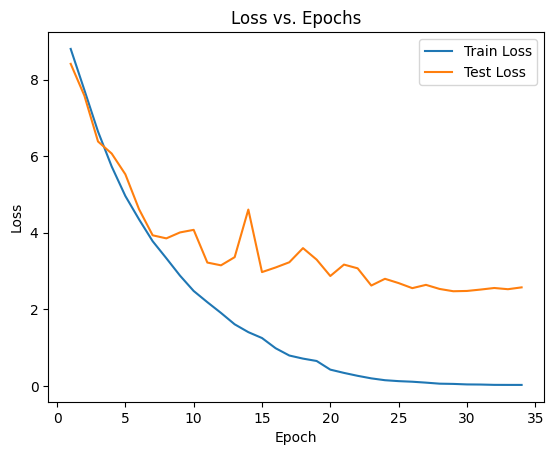

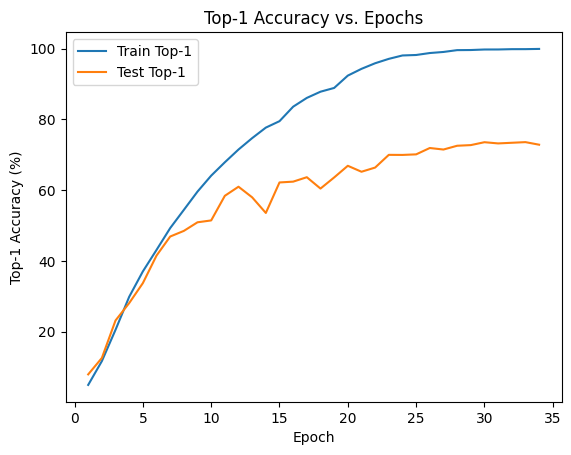

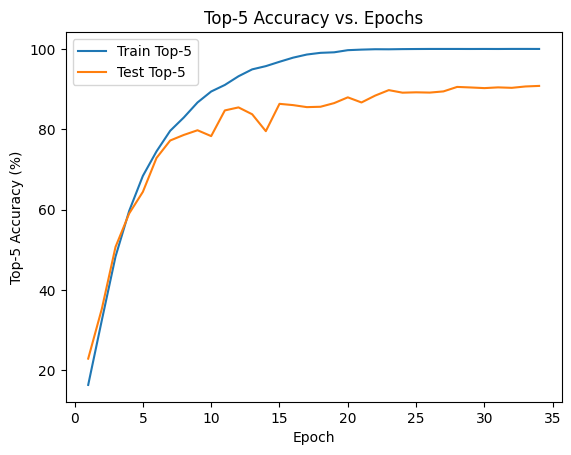

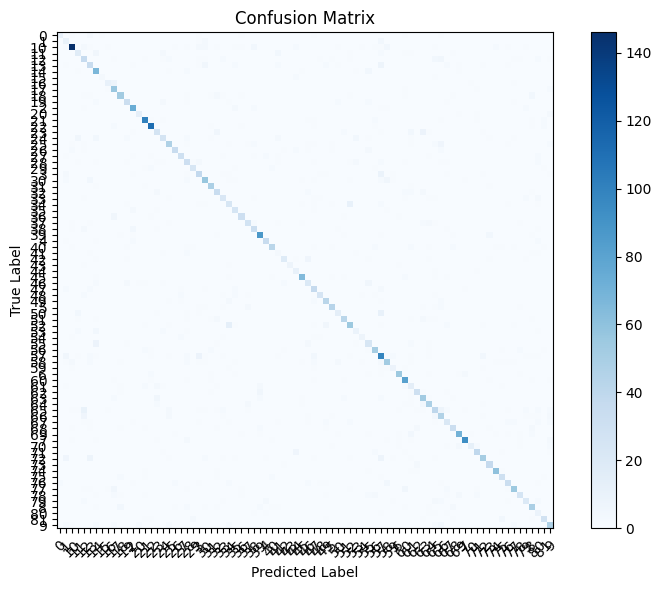

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Collect predictions and true labels for the test set (using L3 as the label)
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = data[3].to(device)  # L3 labels
        # Forward pass: we use the output from the third head
        _, _, out3 = model(images)
        _, preds = torch.max(out3, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# -----------------------------
# Plotting functions
# -----------------------------
def plot_results(history, all_preds, all_labels, class_names):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss vs. Epochs
    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['test_loss'], label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()
    plt.show()
    
    # Plot Top-1 Accuracy vs. Epochs
    plt.figure()
    plt.plot(epochs, history['train_top1'], label='Train Top-1')
    plt.plot(epochs, history['test_top1'], label='Test Top-1')
    plt.xlabel("Epoch")
    plt.ylabel("Top-1 Accuracy (%)")
    plt.title("Top-1 Accuracy vs. Epochs")
    plt.legend()
    plt.show()

    # Plot Top-5 Accuracy vs. Epochs
    plt.figure()
    plt.plot(epochs, history['train_top5'], label='Train Top-5')
    plt.plot(epochs, history['test_top5'], label='Test Top-5')
    plt.xlabel("Epoch")
    plt.ylabel("Top-5 Accuracy (%)")
    plt.title("Top-5 Accuracy vs. Epochs")
    plt.legend()
    plt.show()

    # Compute and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot training curves and the confusion matrix using the helper function
plot_results(history, all_preds, all_labels, train_dataset.labels3)
